<a href="https://colab.research.google.com/github/silveiraluisf/ODIN/blob/main/C%C3%B3pia_de_LUIS_ODIN_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

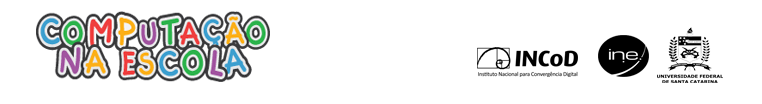

Visual User Interface for Jupyter
Desenvolva o seu modelo de machine learning para a detecção de objetos neste ambiente visual de Jupyter Notebook.

O ambiente visual suporta um processo básico de desenvolvimento de um modelo de ML voltado ao ensino de ML no Ensino Superior.

A interface visual foi criada pela Iniciativa Computação na Escola/INCoD/INE/UFSC.


# Como usar este notebook

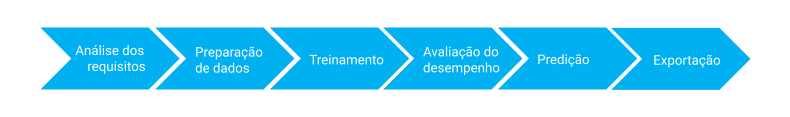

Seguindo esse processo você deve ter coletado os dados no seu google drive e ter feito as anotações das imagens, separando entre pastas de train, valid e test.

Para iniciar a interface visual você precisa primeiro rodar a próxima célula para carregar no notebook a interface visual. Uma vez carregado, não será necessário executá-la novamente durante o uso. É normal demorar pois todos os frameworks são importados nesta etapa.

Em seguida, a última célula deve ser executada para dar início a interface visual, assim sendo possível começar o processo de ML. Atualmente em caso de erro ou caso deseje começar de novo você deverá executar essa célula novamente.

In [7]:
#@title Execute esta célula para preparar a interface visual

#Importacao via python da biblioteca fastai
![ -e /content ] | tee -a >> log.txt && pip install ipywidgets | tee -a >> log.txt && jupyter nbextension enable --py widgetsnbextension | tee -a >> log.txt

# install yolo 8
from ultralytics import YOLO


#install e import Roboflow
!pip install roboflow
from roboflow import Roboflow

#Path Lib
import os
from pathlib import Path
import glob
import re

#Path.ls
from fastai.data import core

#Importações do google colab
from google.colab import drive
from google.colab import widgets as colabwidigets

import matplotlib.pyplot as plt
import numpy as np
import cv2

#Pytorch
import torch

#Images
from IPython.display import Image, display, clear_output

#Importações Ipywidigets
from ipywidgets import widgets as ipywidgets

from IPython.utils import io

class m_Header():
  def __init__(self, header, step):
    href = 'https://github.com/joaopedsa/TCC/blob/master/' + step + '.md'
    html = '<p style=font-family:Arial><b>' + header + '<b/> <a target="_blank" href={}> ?</a> <p>'.format(href)
    self.header = ipywidgets.HTML(html)

class m_Ret():
  def __init__(self, txt, flag):
    if flag == 1:
      self.txt = ipywidgets.HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #339966;">' + txt + '</span></p>')
    if flag == 2:
      self.txt = ipywidgets.HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #ff0000;">' + txt + '</span></p>')

# Função para a conexão com o GDrive
def drive_connect():
  drive.mount('/content/gdrive', force_remount=True)
  drive_connect.root_dir = "/content/gdrive/MyDrive"
  return True

# Função para upload de imagens do Roboflow
def parse_roboflow_snippet(snippet:str) -> str:
  snippet = snippet.replace("!pip install roboflow\n\nfrom roboflow import Roboflow\n","global dataset\n")
  return snippet

# Atributos do Dataset
os.environ["DATASET_DIRECTORY"] = ""
os.environ["CONFIG_YAML"] = ""
dataset_total_images = 0
dataset_dict_labels = {}

# Layouts e Styles
l_txt = ipywidgets.Layout(width='66%')
l_btn = ipywidgets.Layout(width='40%')
l_vbox = ipywidgets.Layout(width='720px')
l_hbox = ipywidgets.Layout(width='90%')
l_req = ipywidgets.Layout(width='95%', height='90px')
l_codesnippet = ipywidgets.Layout(width='66%', height='120px')
l_hidden_red = ipywidgets.Layout(width='90%', visibility = 'hidden')
l_hidden_tra = ipywidgets.Layout(width='90%', visibility = 'hidden')
l_btn_hbox = ipywidgets.Layout(flex_flow='column',align_items='center')
s_desc_wid = {'description_width':'25%'}

# Modelos do yolov5
models = ['yolov5n', 'yolov5s', 'yolov5m', 'yolov5l', 'yolov5x']

# Lista de tipos para exportar
export_list = ['pt', 'onnx', 'tflite', 'torchscript', 'pb']

def total_by_category():
  folders = Path(os.environ["DATASET_DIRECTORY"]).ls()
  total_images = 0
  dict_category = {}
  file_data_yaml = open(os.environ["CONFIG_YAML"])
  data = file_data_yaml.read()
  classes = re.search(r'\[( ?\'[A-z /.-]+\',?)+\]', data).group().replace("[", "").replace("]", "").replace("'", "").split(", ")
  file_data_yaml.close()
  for _class in classes:
    dict_category[_class] = 0
  for folder in folders:
    if os.path.isfile(folder):
      continue
    if Path(folder/"labels").is_dir() and Path(folder/"images").is_dir():
      for file_path in Path(folder/"labels").iterdir():
        file_label = open(file_path)
        for line in file_label.readlines():
          number_class = line.split(" ")[0]
          dict_category[classes[int(number_class)]] += 1
        file_label.close()

  return total_images, dict_category

def generate_images_preview():
  images_preview = []
  folders = Path(os.environ["DATASET_DIRECTORY"]).ls()
  dict_classes_color = {}
  file_data_yaml = open(os.environ["CONFIG_YAML"])
  data = file_data_yaml.read()
  classes = re.search(r'\[( ?\'[A-z /.-]+\',?)+\]', data).group().replace("[", "").replace("]", "").replace("'", "").split(", ")
  file_data_yaml.close()
  labels_path = os.environ["DATASET_DIRECTORY"] + "/train/labels"
  trains_path = os.environ["DATASET_DIRECTORY"] + "/train/images"
  labels = Path(labels_path).ls()
  trains = Path(trains_path).ls()
  labels_dict = {}
  trains_dict = {}
  for label in labels:
    str_label = str(label)
    label_file = str_label.split("/")[-1]
    label_file_name = "".join(label_file.split(".txt")[:-1])
    labels_dict[label_file_name] = label
  for _class in classes:
    dict_classes_color[_class] = list(np.random.choice(range(255),size=3))
  for i in range(6):
    if len(trains) < i:
      break
    str_train = str(trains[i])
    train_file = str_train.split("/")[-1]
    train_file_name = "".join(train_file.split(".jpg")[:-1])
    label = labels_dict[train_file_name]
    file_label = open(label)
    img = cv2.imread(str_train)
    for line in file_label.readlines():
      line_split = line.split(" ")
      number_class = int(line_split[0])
      coordenates = line_split[1:]
      h, w, _ = img.shape
      x = h * float(coordenates[0])
      y = w * float(coordenates[1])
      label_h = (h * float(coordenates[2])) / 2
      label_w = (w * float(coordenates[3])) / 2
      x1 = int(x - label_w)
      y1 = int(y + label_h)
      x2 = int(x + label_w)
      y2 = int(y - label_h)
      _class = classes[number_class]
      r, g, b = dict_classes_color[_class]
      cv2.rectangle(img,  (x1, y1), (x2, y2), (int(r), int(g), int(b)), 3)
      cv2.putText(img, text=_class, org=(x1,y1-10),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0),
            thickness=2, lineType=cv2.LINE_AA)
    image_preview = "img_preview" + str(i) + ".jpg"
    cv2.imwrite(image_preview, img)
    images_preview.append(image_preview)
  return images_preview, dict_classes_color, classes

def render_categories(total_images, category_dict):
  chart_labels = []
  chart_quantities = []
  for i in category_dict:
    chart_labels.append(i)
    chart_quantities.append(category_dict[i])

  x = np.arange(len(chart_labels))
  width = 0.5  # the width of the bars

  fig, ax = plt.subplots()
  rects = ax.bar(x, chart_quantities, width)
  fig.set_figheight(10)
  fig.set_figwidth(12)

  ax.set_ylabel('Objetos')
  ax.set_title('Objetos por categoria')
  ax.set_xticks(x)
  ax.set_xticklabels(chart_labels)
  ax.set_frame_on(False)


# Função que renderiza a janela de Analise De Requisitos
def render_analise_de_requisitos(tab):
  with tab.output_to(0, select=True):
    grid0 = colabwidigets.Grid(1, 1)
    with grid0.output_to(0,0):

      lbl_cat = ipywidgets.Label(value = "Categorias:")
      txta_cat1 = ipywidgets.Textarea(value='',placeholder='Descrição das categorias de objetos que devem ser detectados \nex. 10 categorias de objetos encontrados dentro de casa, que podem interferir no dia a dia de uma pessoa com deficiência visual: Armário, Cachorro, Cadeira, Cama, Criado Mudo, Mesa, Mochila, Porta, Sapato e Sofá',disabled=False,layout=l_req)

      lbl_fontededados = ipywidgets.Label(value = "Fonte de dados:")
      txta_fontededados = ipywidgets.Textarea(value='',placeholder='ex. imagens coletadas pelos criadores do modelo',disabled=False,layout=l_req)

      lbl_qtddedados = ipywidgets.Label(value = "Quantidade de dados:")
      txta_qtddedados = ipywidgets.Textarea(value='',placeholder='ex. No mínimo 30 exemplares para cada categoria',disabled=False,layout=l_req)

      lbl_pdr_img = ipywidgets.Label(value = "Padronização das imagens:")
      txta_pdr_img1 = ipywidgets.Textarea(value='',placeholder='Descrição do formato das imagens \nex. Formato: .jpg, Tamanho: 640x640 pixels',disabled=False,layout=l_req)

      lbl_rotulacao = ipywidgets.Label(value = "Rotulação dos dados:")
      txta_rotulacao = ipywidgets.Textarea(value='',placeholder='Descreve por quem e como foram as anotações das imagens \nex. Por estudantes de curso de computação no ensino superior e rotulados na ferramenta roboflow',disabled=False,layout=l_req)

      lbl_desempenho = ipywidgets.Label(value = "Desempenho Esperado:")
      txta_desempenho = ipywidgets.Textarea(value='',placeholder='Especifique o desempenho esperado (usando uma ou mais medidas (mAP 0.5, mAP 0.95, precision, recall, F1 score) \nex. mAP0.5 ou 0.95: no mínimo 75%, Precision: no minimo 75%, Recall: no minimo 75%...',disabled=False,layout=l_req)

      itens_req = ipywidgets.VBox([ ipywidgets.VBox([lbl_cat, txta_cat1], layout=l_hbox),
                                    ipywidgets.VBox([lbl_fontededados, txta_fontededados], layout=l_hbox),
                                    ipywidgets.VBox([lbl_qtddedados, txta_qtddedados], layout=l_hbox),
                                    ipywidgets.VBox([lbl_pdr_img, txta_pdr_img1], layout=l_hbox),
                                    ipywidgets.VBox([lbl_rotulacao, txta_rotulacao], layout=l_hbox),
                                    ipywidgets.VBox([lbl_desempenho, txta_desempenho], layout=l_hbox)],layout=l_vbox)

      display(itens_req)

# Função que renderiza a janela para preparação dos dados
def render_preparacao_dos_dados(tab):
    with tab.output_to(1, select=False):
        grid1 = colabwidigets.Grid(6,1)

        # Create a tab widget for File Directory and Roboflow Snippet
        sub_tabs = ipywidgets.Tab()
        file_directory_tab = ipywidgets.VBox()
        roboflow_snippet_tab = ipywidgets.VBox()

        # Renderização da tab de importação dos dados via Google Drive
        with grid1.output_to(1,0):
            lbl_path = m_Header('Caminho do seu conjunto de dados', 'PREPARACAO_DOS_DADOS')
            input_path = ipywidgets.Text(placeholder='Insira o caminho do seu conjunto de dados ex: /mask-dataset', value='', layout=l_txt)
            btn_path = ipywidgets.Button(description='Carregar caminho', layout=l_btn, button_style='info', button_color='#58d8ff', disabled=True)
            hbox_path = ipywidgets.HBox([input_path, btn_path], layout=l_hbox)
            vbox_path = ipywidgets.VBox([lbl_path.header, hbox_path], layout=l_vbox)
            file_directory_tab.children = [vbox_path]

            # Check input and enable button
            def check_input_path(_):
                btn_path.disabled = not input_path.value.strip()

            input_path.observe(check_input_path, names='value')

            def on_btn_path_clicked(a):
                with grid1.output_to(1,0):
                    grid1.clear_cell()
                    # Make sure to strip any leading/trailing whitespace and ensure it formats correctly
                    user_input = input_path.value.strip()
                    # Concatenate with the root directory
                    dataset_directory = os.path.join(drive_connect.root_dir, user_input)

                    print(f"Checking directory: {dataset_directory}")  # Debugging output
                    # Set the environment variable to the fully resolved directory path
                    os.environ["DATASET_DIRECTORY"] = dataset_directory

                    # Now check if the directory exists
                    if Path(dataset_directory).is_dir():
                        msg_ret = m_Ret(f'Path: {dataset_directory} definido com sucesso', 1)
                        create_config_files()  # Ensure this function is implemented
                    else:
                        msg_ret = m_Ret(f'Path: {dataset_directory} não encontrado', 2)

                    display(msg_ret.txt)

            btn_path.on_click(on_btn_path_clicked)

        # Renderização da tab de importação dos dados via Roboflow
        with grid1.output_to(0,0):
            lbl_path = m_Header('Code snippet', 'PREPARACAO_DOS_DADOS')
            input_snippet = ipywidgets.Textarea(placeholder='Insira o code snippet exportado do Roboflow', value='', layout=l_codesnippet)
            btn_snippet = ipywidgets.Button(description='Carregar imagens', layout=l_btn, button_style='info', button_color='#58d8ff', disabled=True)
            hbox_snippet = ipywidgets.HBox([input_snippet, btn_snippet], layout=l_hbox)
            vbox_snippet = ipywidgets.VBox([lbl_path.header, hbox_snippet], layout=l_vbox)
            roboflow_snippet_tab.children = [vbox_snippet]

            # Check input and enable button
            def check_input_snippet(_):
                btn_snippet.disabled = not input_snippet.value.strip()

            input_snippet.observe(check_input_snippet, names='value')

            def on_btn_snippet_clicked(a):
                with grid1.output_to(1,0):
                    grid1.clear_cell()
                    with io.capture_output() as captured:
                        rf = Roboflow()
                        global dataset
                        try:
                            exec(parse_roboflow_snippet(input_snippet.value))
                        except Exception as e:
                            msg_ret = m_Ret(f"Erro ao carregar o conjunto de dados: {str(e)}", 2)
                            display(msg_ret.txt)
                    os.environ["DATASET_DIRECTORY"] = dataset.location
                    os.environ["CONFIG_YAML"] = dataset.location + '/data.yaml'
                    if Path(os.environ["DATASET_DIRECTORY"]).is_dir():
                        msg_ret = m_Ret('Conjunto de dados carregado com sucesso', 1)
                    else:
                        msg_ret = m_Ret('Erro no carregamento do conjunto de dados', 2)
                    display(msg_ret.txt)

            btn_snippet.on_click(on_btn_snippet_clicked)
        # Assign tabs
        sub_tabs.children = [file_directory_tab, roboflow_snippet_tab]
        sub_tabs.set_title(0, 'Caminho do Conjunto de Dados')
        sub_tabs.set_title(1, 'Snippet do Roboflow')

         # Place the sub_tabs in the grid
        with grid1.output_to(0, 0):
            display(sub_tabs)

        # Additional activities for dataset information and image preview
        render_dataset_info_and_preview(grid1)

# Function to handle dataset information and image preview
def render_dataset_info_and_preview(grid1):
    # Atividade - Visualizar infos do dataset
    with grid1.output_to(2, 0):
      lbl_dataset_info = ipywidgets.Label(value = "Visualizar informações do conjunto de dados")

      btn_view_total_by_category = ipywidgets.Button(description='Ver quantidade de objetos por categoria', layout=l_btn)
      hbox_dataset_info = [lbl_dataset_info, ipywidgets.Box([btn_view_total_by_category], layout=l_btn_hbox)]
      vbox_dataset_info = ipywidgets.VBox(hbox_dataset_info, layout=l_vbox)
      display(vbox_dataset_info)

      def on_btn_view_total_by_category(_):
        with grid1.output_to(3, 0):
          dataset_total_images, dataset_dict_labels = total_by_category()
          render_categories(dataset_total_images, dataset_dict_labels)

      btn_view_total_by_category.on_click(on_btn_view_total_by_category)

    with grid1.output_to(4, 0):
      lbl_img_preview = ipywidgets.Label(value = "Visualizar conjunto de dados")

      btn_img_preview = ipywidgets.Button(description='Ver exemplos do conjunto', layout=l_btn)
      hbox_img_preview = [lbl_img_preview, ipywidgets.Box([btn_img_preview], layout=l_btn_hbox)]
      vbox_img_preview = ipywidgets.VBox(hbox_img_preview, layout=l_vbox)
      display(vbox_img_preview)

      def on_btn_img_preview(_):
        with grid1.output_to(5,0):
          images_preview, dict_classes_color, classes = generate_images_preview()
          images_widgets = []
          for image_preview in images_preview:
            results = open(image_preview, "rb")
            results_image = results.read()
            results_image_widget = ipywidgets.Image(
                value=results_image,
                format='png',
                width=240,
                height=240,
            )
            images_widgets.append(results_image_widget)
          grid = ipywidgets.GridBox(images_widgets, layout=ipywidgets.Layout(grid_template_columns="repeat(3, 240px)"))
          display(grid)
      btn_img_preview.on_click(on_btn_img_preview)

# Função que renderiza a janela para o treinamento
def render_treinamento(tab):
  with tab.output_to(2, select=False): #):
    grid2 = colabwidigets.Grid(2,1)
    with grid2.output_to(0,0):
      lbl_trainning = m_Header('Treinamento do modelo', 'TREINAMENTO')

      model = ipywidgets.Dropdown(
          options=models,
          value=models[0],
          description='Modelo:',
          disabled=False,
      )

      slider_batches = ipywidgets.IntSlider(min = 1,
                                              max = 128,
                                              step = 1,
                                              value = 16,
                                              description_tooltip='numero de lotes',
                                              description='Tamaho do batch',
                                              layout=l_hbox,
                                              style=s_desc_wid)
      slider_image_size = ipywidgets.IntSlider(min = 64,
                                              max = 1280,
                                              step = 64,
                                              value = 640,
                                              description_tooltip='tamanho das imagens',
                                              description='Tamanho das imagens',
                                              layout=l_hbox,
                                              style=s_desc_wid)
      slider_epochs = ipywidgets.IntSlider(min = 1,
                                              max = 500,
                                              step = 1,
                                              value = 50,
                                              description_tooltip='número de épocas',
                                              description='Quantidade de épocas',
                                              layout=l_hbox,
                                              style=s_desc_wid)


      btn_train_model = ipywidgets.Button(description='Treinar Modelo',tooltip='',layout=l_btn)
      hbox_trainning = [lbl_trainning.header, model, slider_batches, slider_image_size, slider_epochs, ipywidgets.Box([btn_train_model], layout=l_btn_hbox)]
      vbox_trainning = ipywidgets.VBox(hbox_trainning, layout=l_vbox)
      display(vbox_trainning)

      def on_btn_train_model_clicked(b):
        with grid2.output_to(1,0):
          os.environ["BATCHES"] = str(slider_batches.value)
          os.environ["IMAGE_SIZE"] = str(slider_image_size.value)
          os.environ["EPOCHS"] = str(slider_epochs.value)
          os.environ["MODEL"] = str(model.value)
          create_config_files()
          if Path("./yolov5/runs/train").is_dir():
            !rm -rf yolov5/runs/train
          !python yolov5/train.py --img ${IMAGE_SIZE} --batch ${BATCHES} --epochs ${EPOCHS} --data ${CONFIG_YAML} --weights yolov5/${MODEL}.pt

      btn_train_model.on_click(on_btn_train_model_clicked)

# Render Avaliação
def render_avaliacao(tab):
  with tab.output_to(3, select=False):
    grid6 = colabwidigets.Grid(8,1)

    with grid6.output_to(0,0):
      lbl_treinamento = ipywidgets.Label(value='Avaliação do treinamento')
      btn_treinamento = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid)

      box_predict = ipywidgets.VBox([lbl_treinamento, ipywidgets.HBox([btn_treinamento], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_treinamento(b):
        with grid6.output_to(1,0):
          results = open("/content/yolov5/runs/train/exp/results.png", "rb")
          results_image = results.read()
          results_image_widget = ipywidgets.Image(
              value=results_image,
              format='png',
              width=720,
              height=720,
          )
          display(results_image_widget)

      btn_treinamento.on_click(on_btn_treinamento)

    with grid6.output_to(2,0):
      lbl_desempenho = ipywidgets.Label(value='Avaliação do desempenho')
      btn_desempenho = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid)

      box_predict = ipywidgets.VBox([lbl_desempenho, ipywidgets.HBox([btn_desempenho], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_desempenho(b):
        with grid6.output_to(3,0):
          !python yolov5/val.py --data ${CONFIG_YAML} --weights yolov5/runs/train/exp/weights/best.pt

      btn_desempenho.on_click(on_btn_desempenho)

    with grid6.output_to(4,0):
      lbl_f1 = ipywidgets.Label(value='Curva do F1 Score')
      btn_f1 = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid)

      box_predict = ipywidgets.VBox([lbl_f1, ipywidgets.HBox([btn_f1], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_f1(b):
        with grid6.output_to(5,0):
          f1_curve = open("/content/yolov5/runs/train/exp/F1_curve.png", "rb")
          f1_curve_image = f1_curve.read()
          f1_curve_image_widget = ipywidgets.Image(
              value=f1_curve_image,
              format='png',
              width=720,
              height=720,
          )
          display(f1_curve_image_widget)

      btn_f1.on_click(on_btn_f1)

    with grid6.output_to(6,0):
      lbl_matrix = ipywidgets.Label(value='Matriz de Confusão')
      btn_matrix = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid)

      box_predict = ipywidgets.VBox([lbl_matrix, ipywidgets.HBox([btn_matrix], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_confusion_matrix(b):
        with grid6.output_to(7,0):
          confusion_matrix = open("/content/yolov5/runs/train/exp/confusion_matrix.png", "rb")
          confusion_matrix_image = confusion_matrix.read()
          confusion_matrix_image_widget = ipywidgets.Image(
              value=confusion_matrix_image,
              format='png',
              width=720,
              height=720,
          )
          display(confusion_matrix_image_widget)

      btn_matrix.on_click(on_btn_confusion_matrix)

# Render Predição
def render_predicao(tab):
  with tab.output_to(4, select=False):
    grid6 = colabwidigets.Grid(5,1)
    slider_confidence = ipywidgets.IntSlider(min = 1,
                                            max = 100,
                                            step = 1,
                                            value = 10,
                                            description_tooltip='Taxa de Confiança',
                                            description='Confiança',
                                            layout=l_hbox,
                                            style=s_desc_wid)

    with grid6.output_to(0,0):
      lbl_confidence = m_Header('Taxa de Confiança', 'PREDICAO')

      box_confidence = ipywidgets.VBox([lbl_confidence.header, slider_confidence], layout=l_vbox)
      display(box_confidence)

    with grid6.output_to(1,0):
      lbl_prediction = ipywidgets.Label(value="Predição do test set (parte do seu conjunto de dados)")

      btn_pred = ipywidgets.Button(description='Predição', layout=l_btn, style=s_desc_wid)
      box_predict = ipywidgets.VBox([lbl_prediction, ipywidgets.HBox([btn_pred], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_pred(b):
        with grid6.output_to(2,0):
          if Path("./yolov5/runs/detect").is_dir():
            !rm -rf yolov5/runs/detect

          os.environ["CONFIDENCE"] = str(slider_confidence.value/100)
          !python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --img ${IMAGE_SIZE} --conf ${CONFIDENCE} --source ${DATASET_DIRECTORY}/test/images
          images_widgets = []
          for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
            results = open(imageName, "rb")
            results_image = results.read()
            results_image_widget = ipywidgets.Image(
                value=results_image,
                format='png',
                width=320,
                height=320,
            )
            images_widgets.append(results_image_widget)
          grid = ipywidgets.GridBox(images_widgets, layout=ipywidgets.Layout(grid_template_columns="repeat(3, 320px)"))
          display(grid)
      btn_pred.on_click(on_btn_pred)

    with grid6.output_to(3,0):
      lbl_prediction_upload = ipywidgets.Label(value="Predição pelo upload de uma imagem")

      btn_upload = ipywidgets.FileUpload()
      btn_pred = ipywidgets.Button(description='Predição', layout=l_btn, style=s_desc_wid)
      box_predict = ipywidgets.VBox([lbl_prediction_upload, ipywidgets.HBox([btn_upload, btn_pred], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      os.environ["PREDICT_DIR"] = "yolov5/predict/"
      def on_btn_pred(b):
        if not Path("./yolov5/predict/").is_dir():
          !mkdir yolov5/predict

        for index in range(len(btn_upload.data)):
          with open(os.environ["PREDICT_DIR"] + "predict" + str(index) + ".jpg" , "w+b") as i:
              i.write(btn_upload.data[index])

        with grid6.output_to(4,0):
          if Path("./yolov5/runs/detect").is_dir():
            !rm -rf yolov5/runs/detect

          os.environ["CONFIDENCE"] = str(slider_confidence.value/100)
          !python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --img ${IMAGE_SIZE} --conf ${CONFIDENCE} --source ${PREDICT_DIR}
          for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
            display(Image(filename=imageName))
            print("\n")

      btn_pred.on_click(on_btn_pred)

# Render Exportação
def render_exportacao(tab):
  with tab.output_to(5, select=False):
    grid7 = colabwidigets.Grid(3,1)
    with grid7.output_to(0,0):
      lbl_export = m_Header('Exportação do modelo', 'EXPORTACAO')
      lbl_model = ipywidgets.Label(value = "Formato:")
      lbl_path = ipywidgets.Label(value = "Caminho para exportação do modelo treinado:")

      model_export = ipywidgets.Dropdown(
          options=export_list,
          value=export_list[0],
          disabled=False,
      )
      export_path = ipywidgets.Text(placeholder='Insira um caminho de um diretório válido no drive',value='',layout=l_txt)
      btn_export = ipywidgets.Button(description='Exportar', layout=l_btn)
      vbox_dropdown = ipywidgets.VBox([lbl_model, model_export], layout=l_vbox)

      btn_path = ipywidgets.Button(description='Carregar Caminho', layout=l_btn)
      hbox_export = ipywidgets.HBox([export_path, btn_path], layout=l_hbox)
      hbox_btn_export = ipywidgets.HBox([btn_export], layout=l_btn_hbox)
      vbox_export = ipywidgets.VBox([lbl_export.header, vbox_dropdown, lbl_path, hbox_export, hbox_btn_export], layout=l_vbox)

      display(vbox_export)

      def on_btn_path_clicked(a):
        with grid7.output_to(1,0):
          grid7.clear_cell()
          os.environ["EXPORT_DIRECTORY"] = drive_connect.root_dir + export_path.value
          if Path(os.environ["EXPORT_DIRECTORY"]).is_dir():
            msg_ret = m_Ret('Path: ' + os.environ["EXPORT_DIRECTORY"] + '/ definido com sucesso', 1)
          else:
            msg_ret = m_Ret('Path: ' + os.environ["EXPORT_DIRECTORY"] + '/ não encontrado', 2)
          display(msg_ret.txt)
      btn_path.on_click(on_btn_path_clicked)

      def on_btn_export_clicked(b):
        with grid7.output_to(2,0):
          grid7.clear_cell()
          os.environ["MODEL_EXPORT"] = str(model_export.value)
          if Path(os.environ["EXPORT_DIRECTORY"]).is_dir():
            if os.environ["MODEL_EXPORT"] != 'pt':
              !python yolov5/export.py --weights yolov5/runs/train/exp/weights/best.pt --img ${IMAGE_SIZE} --include ${MODEL_EXPORT}
            if os.environ["MODEL_EXPORT"] == 'tflite':
              !cp yolov5/runs/train/exp/weights/best-fp16.tflite ${EXPORT_DIRECTORY}
            else:
              !cp yolov5/runs/train/exp/weights/best.${MODEL_EXPORT} ${EXPORT_DIRECTORY}
            msg_ret = m_Ret('Exportado para: \'' + os.environ["EXPORT_DIRECTORY"] + ' com sucesso', 1)
            display(msg_ret.txt)
          else:
            msg_ret = m_Ret('Diretorio: \'' + os.environ["EXPORT_DIRECTORY"] + ' não encontrado', 2)
            display(msg_ret.txt)

      btn_export.on_click(on_btn_export_clicked)

def create_config_files():
  files = Path(os.environ["DATASET_DIRECTORY"]).ls()
  yaml_config = re.compile(r'[A-z0-9/.-]+.yaml')
  for _file in files:
    if yaml_config.search(str(_file)):
      os.environ["CONFIG_YAML"] = str(_file)

  with open(os.environ["CONFIG_YAML"], 'r+') as f:
    text = f.read()
    text = re.sub(r'train: ([A-z0-9/.-]*)', "train: " + os.environ["DATASET_DIRECTORY"] + "/train/images", text)
    text = re.sub(r'val: ([A-z0-9/.-]*)', "val: " + os.environ["DATASET_DIRECTORY"] + "/valid/images", text)
    f.seek(0)
    f.write(text)
    f.truncate()

def charge_yolov5():
  #clone YOLOv5 and
  !git clone https://github.com/ultralytics/yolov5 | tee -a >> log.txt  # clone repo
  %cd yolov5
  %pip install -qr requirements.txt
  %pip install -q roboflow
  %cd ..

# Função para ser executada, encapsula tudo
def render_odin():
  # Carrega os arquivos do Darknet
  charge_yolov5()
  # Conecta ao Google Drive
  connected = drive_connect()
  clear_output(wait=True)
  if connected:
    # Criação do painel que vai conter as abas
    tab = colabwidigets.TabBar(['Análise de requisitos', 'Preparação de dados', 'Treinamento', 'Avaliação', 'Predição', 'Exportação'])
    # Renderização da Analise de Requisitos
    render_analise_de_requisitos(tab)
    # Renderização da Preparação dos Dados
    render_preparacao_dos_dados(tab)
    # Renderização para o Transfer Learning
    render_treinamento(tab)
    # Renderização para a avaliação
    render_avaliacao(tab)
    # Renderização para a predição
    render_predicao(tab)
    # Renderização para a Exportação
    render_exportacao(tab)

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Checking directory: /content/gdrive/MyDrive/yolov5


HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #339966;">Path: /content/g…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

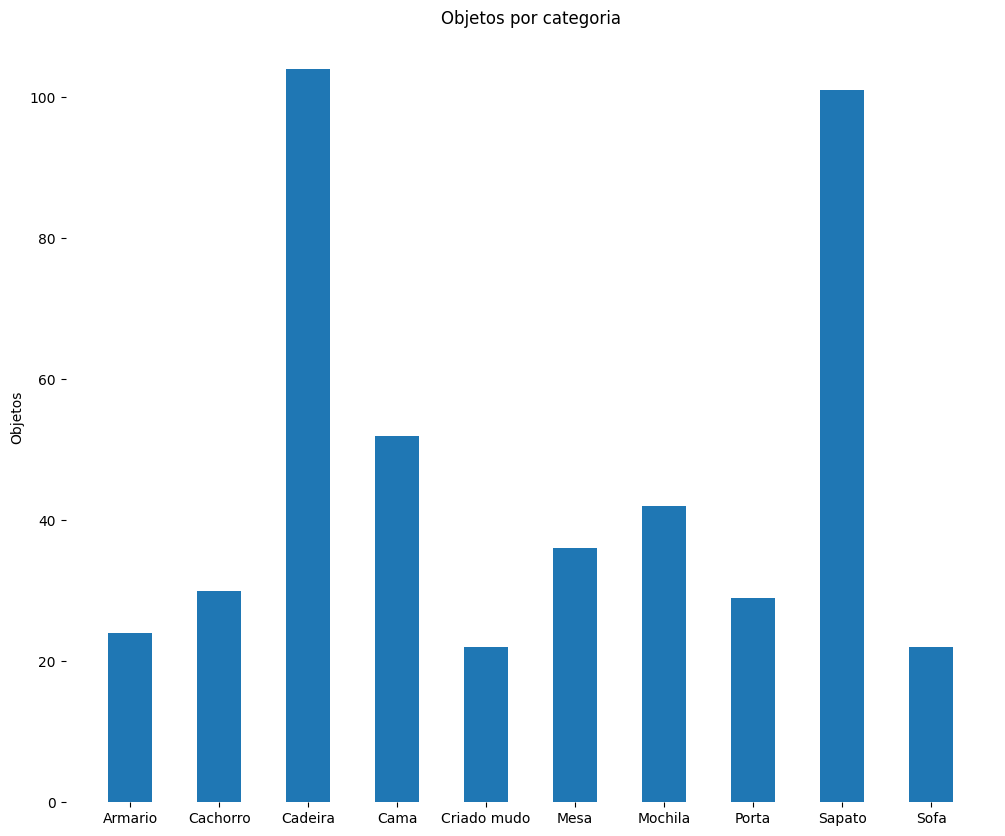

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GridBox(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x…

<IPython.core.display.Javascript object>

In [8]:
render_odin()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()